#### SCOTv1 performance on ambiguous datasets

In [1]:
import yaml
import os
from sklearn.preprocessing import normalize
from types import SimpleNamespace

import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))
from run_baselines.scot import scotv1
from run_baselines.scot import scotv2
from run_baselines.run_mmdma import mmdma_case
from run_baselines.unioncom import UnionCom
from pamona import Pamona
from utils.utils import *
from utils.vis import *
%matplotlib inline

/home/h46zhou/enter/envs/sonata_public/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on cuda


In [2]:
# load parameters and datasets
with open("../cfgs/scGEM.yaml", "r") as file:
        params = yaml.safe_load(file)
params = SimpleNamespace(**params)

data_url1 = os.path.join('..', params.data_path, params.data_url1)
data_url2 = os.path.join('..', params.data_path, params.data_url2)
assert os.path.isfile(data_url1) and os.path.isfile(data_url2)

label_url1 = os.path.join('..', params.data_path, params.label_url1)
label_url2 = os.path.join('..', params.data_path, params.label_url2)
assert os.path.isfile(label_url1) and os.path.isfile(label_url2)

data1 = load_data(data_url1, )
data2 = load_data(data_url2, )
print("data size: data1 = {}, data2 = {}".format(data1.shape, data2.shape))

label1 = load_data(label_url1, ).astype(int)
label2 = load_data(label_url2, ).astype(int)

if params.norm: 
        data1 = normalize(data1, norm=params.norm)
        data2 = normalize(data2, norm=params.norm)

if params.sort_label: 
        data1, label1, _ = sorted_by_label(data1, label1)
        data2, label2, _ = sorted_by_label(data2, label2)

data size: data1 = (177, 34), data2 = (177, 27)


#### 1. SCOT v1

It.  |Err         
-------------------
    0|9.824481e-03|


/home/h46zhou/enter/envs/sonata_public/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


   10|4.695613e-03|
   20|2.063046e-03|
   30|3.744841e-04|
   40|3.306666e-04|
   50|2.489457e-04|
   60|9.049813e-05|
   70|3.207057e-05|
   80|1.247056e-05|
   90|5.343210e-06|
  100|2.458427e-06|
  110|1.183952e-06|
  120|5.875370e-07|
  130|2.978118e-07|
  140|1.533441e-07|
  150|7.989168e-08|
  160|4.198873e-08|
  170|2.220973e-08|
  180|1.180208e-08|
  190|6.292182e-09|
It.  |Err         
-------------------
  200|3.362413e-09|
  210|1.799726e-09|
  220|9.643923e-10|
It.  |Err         
-------------------
    0|4.029015e-03|
   10|1.417322e-05|
   20|1.634889e-08|
   30|2.187346e-11|


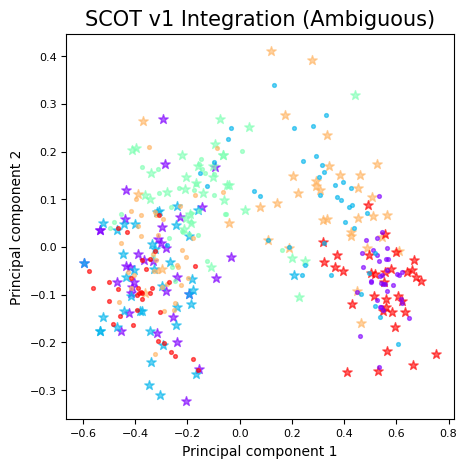

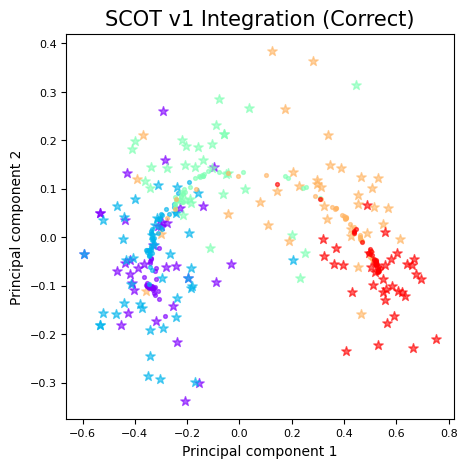

In [3]:
# Ambiguous solution
scot_instance = scotv1.SCOT(data1, data2)
X_aligned_case1, y_aligned_case1 = scot_instance.align(k=20, e=0.001, mode='connectivity', metric='correlation', normalize=False)

# Correct solution
scot_instance = scotv1.SCOT(data1, data2)
X_aligned_case2, y_aligned_case2 = scot_instance.align(k=25, e=0.01, mode='connectivity', metric='correlation', normalize=False)

plt_mapping_by_labels(X_aligned_case1, y_aligned_case1, label1, label2, title = "SCOT v1 Integration (Ambiguous)", a = 0.6, show=True)  
plt_mapping_by_labels(X_aligned_case2, y_aligned_case2, label1, label2, title = "SCOT v1 Integration (Correct)", a = 0.6, show=True)  

#### 2. SCOT v2

computing intra-domain graph distances
running pairwise dataset alignments
Unbalanced GW step: 0
Unbalanced GW step: 10
FLAGS [True]
Projection Method embedding
computing intra-domain graph distances
running pairwise dataset alignments
Unbalanced GW step: 0
Unbalanced GW step: 10
FLAGS [True]
Projection Method embedding


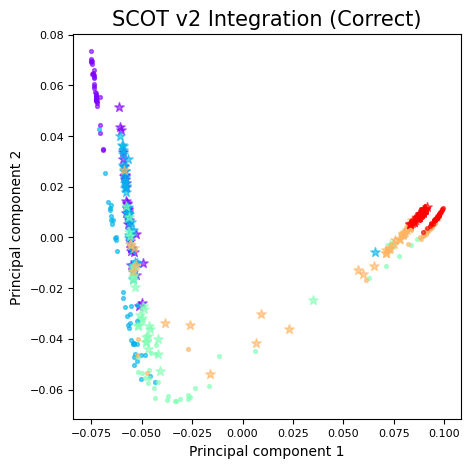

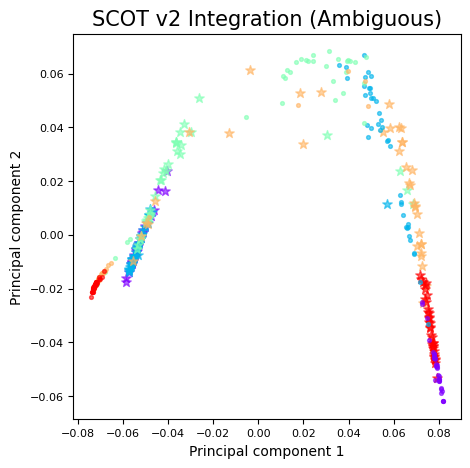

In [10]:
# Correct case
scot_instance = scotv2.SCOTv2([data1, data2])
integrated_data_case1 = scot_instance.align(k=22, eps=0.01, rho=0.01, mode='connectivity', metric='correlation', normalize=False) 

# Ambiguous case
scot_instance = scotv2.SCOTv2([data1, data2])
integrated_data_case2 = scot_instance.align(k=20, eps=0.01, rho=0.1,  mode='connectivity', metric='correlation', normalize=False)

plt_mapping_by_labels(integrated_data_case1[0], integrated_data_case1[1], label1, label2, title = "SCOT v2 Integration (Correct)", a = 0.6, show=True)  
plt_mapping_by_labels(integrated_data_case2[0], integrated_data_case2[1], label1, label2, title = "SCOT v2 Integration (Ambiguous)", a = 0.6, show=True)  

#### 3. MMDMA

Number of dimensions of latent space... 4
Calculated sigma: 0.09352907342054095
Number of dimensions of latent space... 4
Calculated sigma: 0.09745276899133515


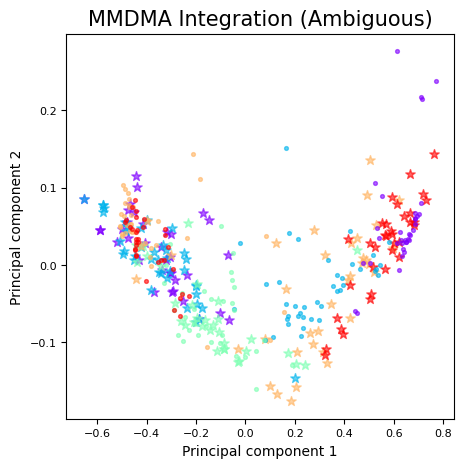

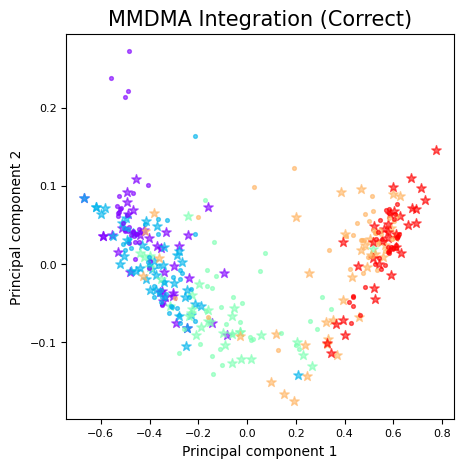

In [5]:
# Ambiguous case
data1_new_case1, data2_new_case1, mapping_case1 = mmdma_case(data1, data2, lambda1=1e-3, lambda2=1e-3, seed=2, epoch=5000, sigma=0.0, nfeat=4, kernel="linear")

# Correct case
data1_new_case2, data2_new_case2, mapping_case2 = mmdma_case(data1, data2, lambda1=1e-3, lambda2=1e-3, seed=0, epoch=5000, sigma=0.0, nfeat=4, kernel="linear")

plt_mapping_by_labels(data1_new_case1, data2_new_case1, label1, label2, title = "MMDMA Integration (Ambiguous)", a = 0.6, show=True)  
plt_mapping_by_labels(data1_new_case2, data2_new_case2, label1, label2, title = "MMDMA Integration (Correct)", a = 0.6, show=True)  

#### 4. Pamona

Pamona start!
use random seed: 666
Epoch.|Loss        
-------------------
    0|2.858975e-03|
   10|3.878290e-04|
   20|1.372462e-06|
   30|4.050416e-09|
   40|1.194679e-11|
Pamona Done! takes 1.251651 seconds
Pamona start!
use random seed: 666
Epoch.|Loss        
-------------------
    0|2.910534e-03|
   10|4.387183e-05|
   20|5.135878e-08|
   30|5.989766e-11|
Pamona Done! takes 0.304236 seconds


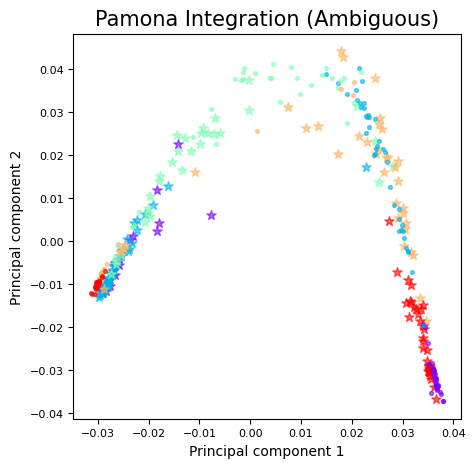

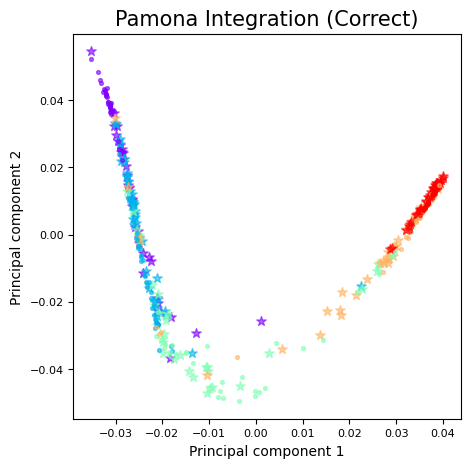

In [6]:
# Ambiguous case
pa = Pamona.Pamona(epsilon=0.01, Lambda=10, n_neighbors=17, n_shared=[138], mode='connectivity', metric='correlation')
integrated_data_case1, mapping_case1 = pa.run_Pamona([data1, data2])

# Correct case
pa = Pamona.Pamona(epsilon=0.01, Lambda=10, n_neighbors=11, n_shared=[138])
integrated_data_case2, mapping_case2 = pa.run_Pamona([data1, data2])

plt_mapping_by_labels(integrated_data_case1[0], integrated_data_case1[1], label1, label2, title = "Pamona Integration (Ambiguous)", a = 0.6, show=True)  
plt_mapping_by_labels(integrated_data_case2[0], integrated_data_case2[1], label1, label2, title = "Pamona Integration (Correct)", a = 0.6, show=True)  

#### 5. UnionCom

use random seed: 666
Shape of Raw data
Dataset 0: (177, 34)
Final k = 6
Dataset 1: (177, 27)
Final k = 6
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/2000] err:1.9878 alpha:0.9670
epoch:[200/2000] err:2.0229 alpha:1.1450
epoch:[300/2000] err:1.5910 alpha:1.3947
epoch:[400/2000] err:1.3350 alpha:1.5091
epoch:[500/2000] err:1.2344 alpha:1.5517
epoch:[600/2000] err:1.1972 alpha:1.5669
epoch:[700/2000] err:1.1818 alpha:1.5721
epoch:[800/2000] err:1.1738 alpha:1.5741
epoch:[900/2000] err:1.1683 alpha:1.5752
epoch:[1000/2000] err:1.1640 alpha:1.5758
epoch:[1100/2000] err:1.1597 alpha:1.5763
epoch:[1200/2000] err:1.1560 alpha:1.5767
epoch:[1300/2000] err:1.1526 alpha:1.5771
epoch:[1400/2000] err:1.1492 alpha:1.5775
epoch:[1500/2000] err:1.1460 alpha:1.5778
epoch:[1600/2000] err:1.1430 alpha:1.5781
epoch:[1700/2000] err:1.1404 alpha:1.5784
epoch:[1800/2000] err:1.1379 alpha:1.5786
epoch:[1900/2000] err:1.1356 alpha:1.5788
epoc

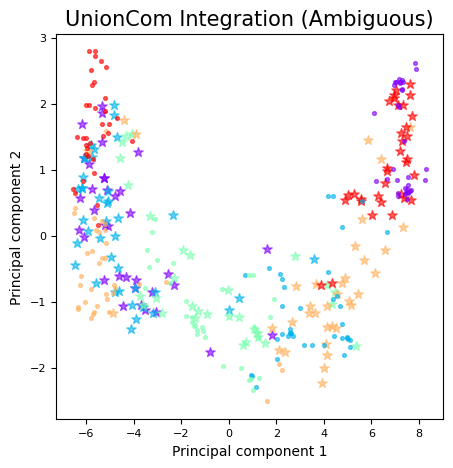

use random seed: 666
Shape of Raw data
Dataset 0: (177, 34)
Final k = 18
Dataset 1: (177, 27)
Final k = 18
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/2000] err:1.4710 alpha:1.2065
epoch:[200/2000] err:1.6413 alpha:1.3702
epoch:[300/2000] err:1.3245 alpha:1.5712
epoch:[400/2000] err:1.0188 alpha:1.7237
epoch:[500/2000] err:0.8835 alpha:1.7986
epoch:[600/2000] err:0.8274 alpha:1.8336
epoch:[700/2000] err:0.8011 alpha:1.8507
epoch:[800/2000] err:0.7863 alpha:1.8597
epoch:[900/2000] err:0.7763 alpha:1.8649
epoch:[1000/2000] err:0.7688 alpha:1.8680
epoch:[1100/2000] err:0.7626 alpha:1.8701
epoch:[1200/2000] err:0.7572 alpha:1.8715
epoch:[1300/2000] err:0.7525 alpha:1.8725
epoch:[1400/2000] err:0.7484 alpha:1.8733
epoch:[1500/2000] err:0.7446 alpha:1.8740
epoch:[1600/2000] err:0.7412 alpha:1.8746
epoch:[1700/2000] err:0.7380 alpha:1.8750
epoch:[1800/2000] err:0.7350 alpha:1.8755
epoch:[1900/2000] err:0.7322 alpha:1.8759
ep

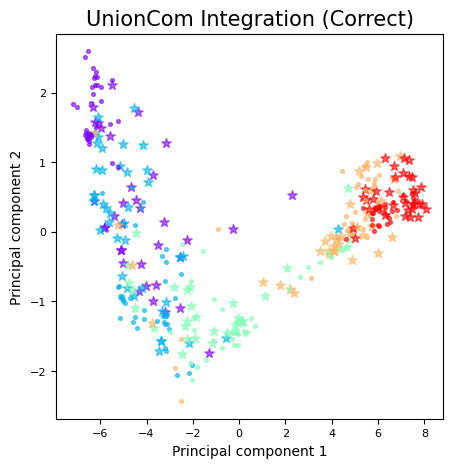

In [7]:
# Ambiguous case
uc = UnionCom.UnionCom(rho=1, kmin=6, epoch_pd=2000, epsilon=0.01, log_pd=100)
integrated_data_case1, mapping_case1 = uc.fit_transform(dataset=[data1,data2])

# Correct case
uc = UnionCom.UnionCom(rho=2, kmin=18, epoch_pd=2000, epsilon=0.01, log_pd=100)
integrated_data_case2, mapping_case2 = uc.fit_transform(dataset=[data1,data2])

plt_mapping_by_labels(integrated_data_case1[0], integrated_data_case1[1], label1, label2, title = "UnionCom Integration (Ambiguous)", a = 0.6, show=True)  
plt_mapping_by_labels(integrated_data_case2[0], integrated_data_case2[1], label1, label2, title = "UnionCom Integration (Correct)", a = 0.6, show=True)  